In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ete3
from scipy.optimize import minimize
from tqdm import tqdm


/home/phil/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
gg_tree_path = "greengenes/data/gg_13_5_otus_99_annotated.tree"
seed_tree_path = "seedplants/tree.nwk"
seed_traits_path = "seedplants/traits.csv"

In [3]:
tree = ete3.Tree(seed_tree_path, format=1)
print(tree)


      /-LITU
     |
     |            /-COAL
     |         /-|
     |        |   \-COST
     |        |
     |        |      /-CABI
     |      /-|   /-|
     |     |  |  |  |   /-FRNI
     |     |  |  |   \-|
     |     |  |  |     |   /-FRAM
     |     |   \-|      \-|
     |     |     |         \-FRPE
     |     |     |
     |     |     |   /-NEMU
     |     |      \-|
     |     |         \-VICA
     |     |
     |     |                        /-CACA
     |     |                     /-|
     |     |                  /-|   \-OSVI
     |     |                 |  |
     |     |                 |   \-COCO
     |     |               /-|
     |     |              |  |      /-ALCR
     |     |              |  |   /-|
     |     |              |  |  |   \-ALRU
     |     |              |   \-|
     |     |              |     |   /-BEPO
     |     |              |      \-|
     |     |            /-|        |   /-BEPA
     |     |           |  |         \-|
     |     |           |  |    

# Basic definitions and sanity checks
Source: https://lukejharmon.github.io/pcm/pdf/phylogeneticComparativeMethods.pdf section 4.3


In [4]:
from src.phylogenetic_signal import PagelsLambda
# Factored out the PagelsLambda class into a separate file

pl = PagelsLambda(seed_tree_path, format=0)


In [5]:
x = np.random.multivariate_normal(mean=np.zeros(pl.N), cov=pl.C)
pl.fit(x)
pl.lam

1.0

100%|██████████| 21/21 [00:33<00:00,  1.61s/it]


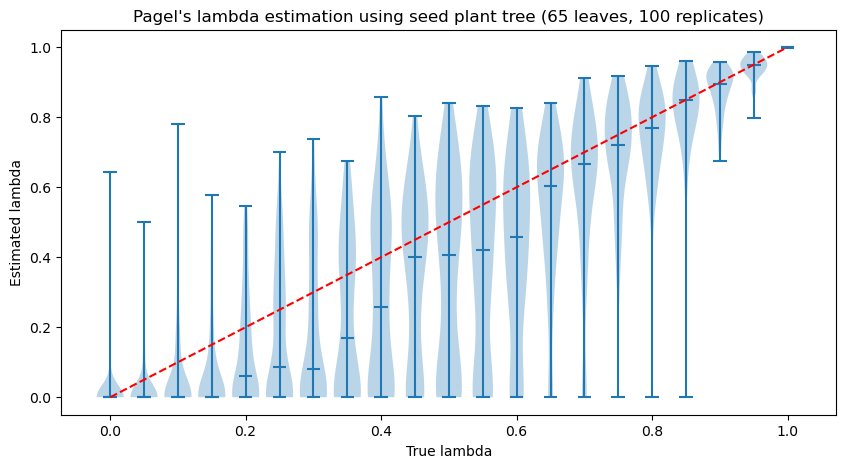

In [8]:
# Sanity check 1: should closely resemble y=x
# Check agreement with simulated data for a variety of lambdas

n_reps = 100

estimates = []
lambdas = np.linspace(0, 1, 21)
# Test estimates for a variety of lambdas
for lam in tqdm(lambdas):
    lam_ests = []
    for i in range(n_reps):
        pl.fit(
            np.random.multivariate_normal(np.zeros(pl.N), pl.rescale_cov(lam))
        )
        lam_ests.append(pl.lam)
    estimates.append(lam_ests)

# Boxplots!
fig = plt.figure(figsize=(10, 5))
plt.violinplot(
    dataset=estimates,
    positions=lambdas,
    widths=[0.04] * len(lambdas),
    showmedians=True,
)
plt.plot(lambdas, lambdas, color="red", linestyle="--", label="True lambda")
plt.xlabel("True lambda")
plt.ylabel("Estimated lambda")
plt.title(f"Pagel's lambda estimation using seed plant tree ({pl.N} leaves, {n_reps} replicates)")

plt.show()


In [7]:
# Sanity check 2: agreement with textbook example
# The Garland (1992) data is not provided, so I'm going to use this example instead:
# https://github.com/simjoly/CourseComparativeMethods/blob/master/lecture6/PD.pdf

# Load data
traits = pd.read_csv(
    "./seedplants/traits.csv", sep=";", decimal=",", index_col=0
).dropna()
tree = ete3.Tree("./seedplants/tree.nwk", format=0)

# Match leaves to traits
pl = PagelsLambda(tree)
traits = traits.reindex(pl.leaf_order)

# Fit lambda for each trait
print("trait\t\tlambda\t\tlnL\t\tnull\t\tlikelihood ratio")
for col in traits.columns:
    if col == "Occurrence":
        continue
    try:
        pl.fit(traits[col].values)
        print(
            f"{col}",
            f"{pl.lam:.2f}",
            f"{pl.lnL:.2f}",
            f"{pl.null_lnL:.2f}",
            f"{np.exp(pl.lnL - pl.null_lnL):.0f}",
            sep="\t\t",
        )
    except Exception as e:
        # print(f"{col}: {e}")
        pass

# Expected:

# trait   | lambda | lnL  | null
# --------+--------+------+-----
# maxH    | 0.49   |-206  | -207
# Wd      | 0.76   |  59  |   42
# Sm      | 0.91   |-521  | -531
# Shade   | 0.95   | -83  |  -88
# N       | 0.67   | -18  |  -41


trait		lambda		lnL		null		likelihood ratio
maxH		0.49		-206.66		-206.96		1
Wd		0.76		58.99		52.21		882
Sm		0.91		-521.91		-531.18		10654
Shade		0.95		-83.07		-88.30		188
N		0.67		-18.07		-41.11		10135144514
